In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


1. Imports & Paths

In [3]:
# Final Report - Global imports and paths
import os, json, random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.metrics import f1_score
import pickle
import matplotlib.pyplot as plt



In [4]:
import json
import os

ROOT = "/content/drive/MyDrive/7015/vqa_rad"
IMAGE_FOLDER = os.path.join(ROOT, "VQA_RAD Image Folder")
PROC = os.path.join(ROOT, "processed")

topk_path = os.path.join(PROC, "topK_info.json")
train_json = os.path.join(PROC, "train_filtered.json")
val_json   = os.path.join(PROC, "val_filtered.json")

topk_info = json.load(open(topk_path, "r", encoding="utf-8"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LABELS = topk_info["topK"]              # list of answer strings
label2id = {a: i for i, a in enumerate(LABELS)}
id2label = {i: a for a, i in label2id.items()}

print("Top-K =", len(LABELS))


Top-K = 50


2. Vocabulary for Questions (Simple & Sufficient)

In [5]:
def build_vocab(data, min_freq=1):
    from collections import Counter
    counter = Counter()
    for x in data:
        counter.update(x["question"].lower().split())
    vocab = {"<pad>":0, "<unk>":1}
    for w,c in counter.items():
        if c >= min_freq:
            vocab[w] = len(vocab)
    return vocab


In [6]:
train_data = json.load(open(train_json,'r',encoding='utf-8'))
vocab = build_vocab(train_data)


3. Dataset (Shared Label Mapping, Correct Design)

In [7]:
class VQADataset(Dataset):
    def __init__(self, json_path, image_folder, vocab, transform=None, max_len=20):
        self.items = json.load(open(json_path,'r',encoding='utf-8'))
        self.image_folder = image_folder
        self.vocab = vocab
        self.transform = transform
        self.max_len = max_len
        self.label2id = label2id


    def encode_question(self, q):
        tokens = q.lower().split()[:self.max_len]
        ids = [self.vocab.get(t, self.vocab["<unk>"]) for t in tokens]
        ids += [self.vocab["<pad>"]] * (self.max_len - len(ids))
        return torch.tensor(ids, dtype=torch.long)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img_path = os.path.join(self.image_folder, it["image_file"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        q_ids = self.encode_question(it["question"])
        label = self.label2id[it["answer"]]

        return img, q_ids, label, it["answer_type"]


4. DataLoaders

In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_ds = VQADataset(train_json, IMAGE_FOLDER, vocab, transform)
val_ds   = VQADataset(val_json, IMAGE_FOLDER, vocab, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


5. CNN + LSTM Model

In [9]:
class CNN_LSTM_VQA(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super().__init__()

        # Image encoder
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()   # (B, 512)

        # Question encoder
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=300,
            hidden_size=512,
            batch_first=True
        )

        # Fusion + classifier (ONLY ONE)
        self.fc = nn.Sequential(
            nn.Linear(512 + 512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, image, question):
        img_feat = self.cnn(image)                # (B, 512)
        q_embed = self.embedding(question)         # (B, T, 300)
        _, (h, _) = self.lstm(q_embed)
        q_feat = h[-1]                             # (B, 512)

        fused = torch.cat([img_feat, q_feat], dim=1)
        return self.fc(fused)


6. Training Loop

In [11]:
model = CNN_LSTM_VQA(
    vocab_size=len(vocab),
    num_classes=len(LABELS)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 45.3MB/s]


In [18]:
EPOCHS = 5
model_path = '/content/drive/MyDrive/7015/vqa_rad/cnn_lstm_model_finalSSS.pth'
history_path = '/content/drive/MyDrive/7015/vqa_rad/cnn_lstm_historySSS.pkl'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
train_losses = []
val_accuracies = []
macro_f1s = []
weighted_f1s = []


In [20]:
print("Before training:", len(train_losses))


Before training: 0


In [21]:
best_val_acc = 0.0
for epoch in range(EPOCHS):

    # -------- Train --------
    model.train()
    total_loss = 0

    for imgs, qs, labels, ans_type in train_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs, qs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # -------- Validation --------
    model.eval()
    correct, total = 0, 0
    all_gt, all_pred = [], []

    with torch.no_grad():
      for imgs, qs, labels, ans_types in val_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)
        preds = model(imgs, qs).argmax(dim=1)


        for i in range(len(ans_types)):
          if ans_types[i].upper() == "CLOSED":
            correct += int(preds[i] == labels[i])
            total += 1
            all_gt.append(labels[i].item())
            all_pred.append(preds[i].item())


    val_acc = correct / total
    val_accuracies.append(val_acc)
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      torch.save(model.state_dict(), model_path)
      print(f"New best model saved (Val Acc = {best_val_acc:.4f})")


    macro_f1 = f1_score(all_gt, all_pred, average="macro")
    weighted_f1 = f1_score(all_gt, all_pred, average="weighted")

    macro_f1s.append(macro_f1)
    weighted_f1s.append(weighted_f1)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss={avg_loss:.4f} | "
        f"Val Acc={val_acc:.4f} | "
        f"Macro F1={macro_f1:.4f} | "
        f"Weighted F1={weighted_f1:.4f}"
    )


New best model saved (Val Acc = 0.5664)
Epoch [1/5] | Train Loss=2.3472 | Val Acc=0.5664 | Macro F1=0.2044 | Weighted F1=0.5006
New best model saved (Val Acc = 0.6195)
Epoch [2/5] | Train Loss=1.6360 | Val Acc=0.6195 | Macro F1=0.2511 | Weighted F1=0.6111
New best model saved (Val Acc = 0.6372)
Epoch [3/5] | Train Loss=1.4993 | Val Acc=0.6372 | Macro F1=0.2515 | Weighted F1=0.6135
New best model saved (Val Acc = 0.6549)
Epoch [4/5] | Train Loss=1.4329 | Val Acc=0.6549 | Macro F1=0.2653 | Weighted F1=0.6459
Epoch [5/5] | Train Loss=1.2430 | Val Acc=0.6018 | Macro F1=0.2022 | Weighted F1=0.5913


In [12]:
# =========================
# Save model
# =========================
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# =========================
# Save training history
# =========================
history = {
    "train_losses": train_losses,
    "val_accuracies": val_accuracies,
    "macro_f1s": macro_f1s,
    "weighted_f1s": weighted_f1s,
    "epochs": EPOCHS
}

with open(history_path, "wb") as f:
    pickle.dump(history, f)

print(f"History saved to {history_path}")


NameError: name 'model_path' is not defined

In [13]:
# =========================
# Load history (explicit)
# =========================
with open(history_path, "rb") as f:
    history = pickle.load(f)

train_losses   = history['train_losses']
val_accuracies = history['val_accuracies']
macro_f1s      = history['macro_f1s']       # ← 改这里
weighted_f1s   = history['weighted_f1s']    # ← 改这里

print("Loaded epochs:", len(train_losses))



NameError: name 'history_path' is not defined

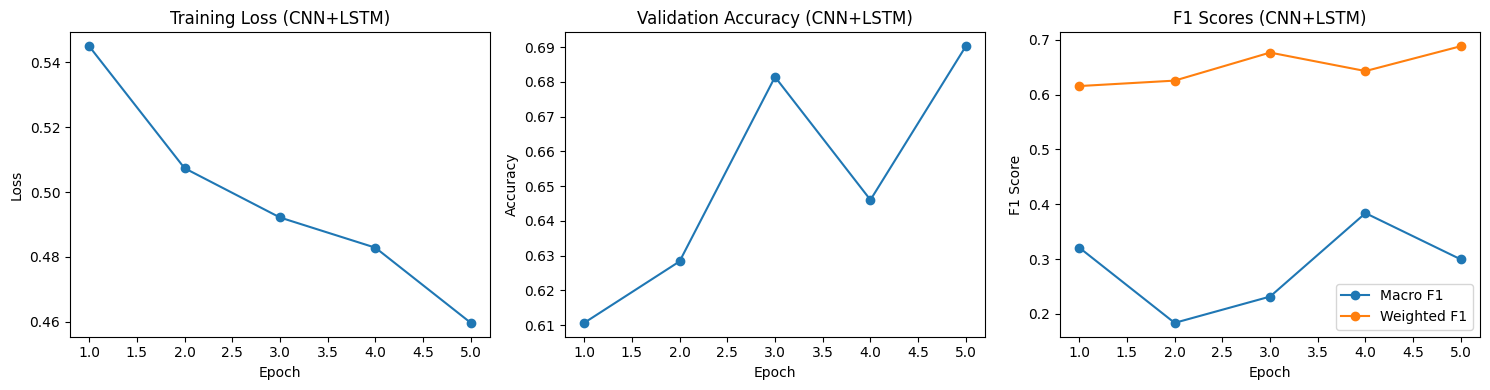

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15,4))

# ---- Loss ----
plt.subplot(1,3,1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss (CNN+LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# ---- Accuracy ----
plt.subplot(1,3,2)
plt.plot(epochs, val_accuracies, marker='o')
plt.title("Validation Accuracy (CNN+LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# ---- F1 ----
plt.subplot(1,3,3)
plt.plot(epochs, macro_f1s, label="Macro F1", marker='o')
plt.plot(epochs, weighted_f1s, label="Weighted F1", marker='o')
plt.title("F1 Scores (CNN+LSTM)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(
    torch.load(model_path, map_location=device)
)

model.to(device)
model.eval()
closed_correct = closed_total = 0
open_correct = open_total = 0
global_idx = 0

with torch.no_grad():
    for imgs, qs, labels,ans_type in val_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)
        preds = model(imgs, qs).argmax(dim=1)

        for i in range(len(labels)):
            item = val_ds.items[global_idx]
            ans_type = item.get("answer_type", "").lower()

            if "close" in ans_type:
                closed_total += 1
                if preds[i] == labels[i]:
                    closed_correct += 1
            else:
                open_total += 1
                if preds[i] == labels[i]:
                    open_correct += 1

            global_idx += 1

print(f"Closed-ended Accuracy: {closed_correct / max(1, closed_total):.4f}")
print(f"Open-ended Accuracy:   {open_correct / max(1, open_total):.4f}")


Closed-ended Accuracy: 0.6903
Open-ended Accuracy:   0.4828


Found sample at index: 28


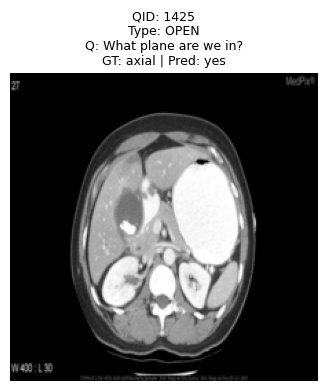

In [31]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# --- Use QID to select a specific validation sample ---
TARGET_QID = 1425
idx = None
for i, item in enumerate(val_ds.items):
    if item.get("qid") == TARGET_QID:
        idx = i
        break

assert idx is not None, "QID not found in validation set"
print("Found sample at index:", idx)

# --- Model inference ---
model.eval()
to_pil = ToPILImage()

img, q_ids, label,ans_type = val_ds[idx]
item = val_ds.items[idx]

question    = item["question"]
answer_type = item.get("answer_type", "unknown")
qid         = item.get("qid")
gt = id2label[label]


with torch.no_grad():
    pred = model(
        img.unsqueeze(0).to(device),
        q_ids.unsqueeze(0).to(device)
    ).argmax(dim=1).item()

pred_ans = id2label[pred]

# --- Display result ---
img_pil = to_pil(img)

plt.figure(figsize=(4,4))
plt.imshow(img_pil)
plt.axis("off")
plt.title(
    f"QID: {qid}\n"
    f"Type: {answer_type}\n"
    f"Q: {question}\n"
    f"GT: {gt} | Pred: {pred_ans}",
    fontsize=9
)
plt.show()


In [ ]:
# Yes/No accuracy analysis

yes_no_ids = [
    i for i, a in id2label.items()
    if a.lower() in ["yes", "no"]
]

yn_correct, yn_total = 0, 0

model.eval()
with torch.no_grad():
    for imgs, qs, labels,ans_type in val_loader:
        imgs, qs, labels = imgs.to(device), qs.to(device), labels.to(device)
        preds = model(imgs, qs).argmax(dim=1)

        for p, l in zip(preds, labels):
            if l.item() in yes_no_ids:
                yn_total += 1
                if p.item() == l.item():
                    yn_correct += 1

print("Yes/No Accuracy:", yn_correct / max(1, yn_total))



Yes/No Accuracy: 0.7
